# Test Russian Roulette (RR)

This test ensures that as the path depth at which RR starts increased, the errors due to its use vanishes

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import mitsuba as mi
import drjit as dr

from sionna.rt import Scene, Transmitter, PlanarArray, Receiver
from instant_rm import MapTracer

In [3]:
# Setup scene

scene_file = "../scenes/box_multi/box_multi.xml"
tx_position = np.array([0., 0., 4.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

# Path loss map used for evaluation
cm_center = np.array([0., 0., 1.0])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([12., 12.])
cm_cell_size = np.array([0.1, 0.1])

num_samples = int(1e7)
max_depth = 10

# Probability of terminating rays for the RR
rr_prob = 0.95
# Path depth at which RR starts
rr_depths = [-1, 1, 3, 5, 7] # -1 means no RR

scene = mi.load_file(scene_file)
params = mi.traverse(scene)

# Compute material complex relative permittivities to ensure that
# Sionna and the evaluated tracer scene use the same values
eta_complex_mats = {}
scene = mi.load_file(scene_file)
#
eta_r = mi.traverse(scene)['mat-itu_concrete.eta_r'].numpy()[0]
eta_i = mi.traverse(scene)['mat-itu_concrete.eta_i'].numpy()[0]
eta_complex_mats['itu_concrete'] = eta_r - 1j*eta_i
#
eta_r = mi.traverse(scene)['mat-itu_marble.eta_r'].numpy()[0]
eta_i = mi.traverse(scene)['mat-itu_marble.eta_i'].numpy()[0]
eta_complex_mats['itu_marble'] = eta_r - 1j*eta_i
#
eta_r = mi.traverse(scene)['mat-itu_wood.eta_r'].numpy()[0]
eta_i = mi.traverse(scene)['mat-itu_wood.eta_i'].numpy()[0]
eta_complex_mats['itu_wood'] = eta_r - 1j*eta_i
#
eta_r = mi.traverse(scene)['mat-itu_brick.eta_r'].numpy()[0]
eta_i = mi.traverse(scene)['mat-itu_brick.eta_i'].numpy()[0]
eta_complex_mats['itu_brick'] = eta_r - 1j*eta_i

In [4]:
# Trace the RMS-DS map
cms_db = {}
for rr_depth in rr_depths:

    tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples, max_depth,
                       rr_depth=rr_depth, rr_prob=rr_prob)

    cm,_,_,_ = tracer(tx_position, tx_orientation, los=False, loop_record=False)
    cm_db = 10.0*np.log10(cm.numpy()).T
    cms_db[rr_depth] = cm_db

/tmp/ipykernel_935354/467723139.py:11: RuntimeWarning: divide by zero encountered in log10
  cm_db = 10.0*np.log10(cm.numpy()).T


In [5]:
# Sionna as reference

scene = Scene(scene_file)
scene.frequency = fc

for rm_name, rm in scene.radio_materials.items():
    if not rm.is_used:
        continue
    err = np.abs(rm.complex_relative_permittivity - eta_complex_mats[rm_name])
    print(f"Mistmatch for complex relative permittivity of material {rm_name} : {err}")

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern=tx_pattern,
                             polarization="V",
                             polarization_model=2)

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="VH",
                             polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
scene.add(tx)

# Compute path loss map
cm_ref = scene.coverage_map(cm_center=cm_center, cm_orientation=cm_orientation, cm_size=cm_size,
                            cm_cell_size=cm_cell_size, num_samples=num_samples, max_depth=max_depth,
                            check_scene=False, los=False, diffraction=False, scattering=False)
cm_ref = cm_ref.as_tensor().numpy()[0]
cm_ref_db = 10.0*np.log10(cm_ref)

Mistmatch for complex relative permittivity of material itu_concrete : 0.0
Mistmatch for complex relative permittivity of material itu_brick : 0.0
Mistmatch for complex relative permittivity of material itu_wood : 0.0
Mistmatch for complex relative permittivity of material itu_marble : 0.0


/tmp/ipykernel_935354/1897294848.py:40: RuntimeWarning: divide by zero encountered in log10
  cm_ref_db = 10.0*np.log10(cm_ref)


/tmp/ipykernel_935354/1300449479.py:8: RuntimeWarning: invalid value encountered in subtract
  err_map = np.abs(cm_ref_db - cm_db)


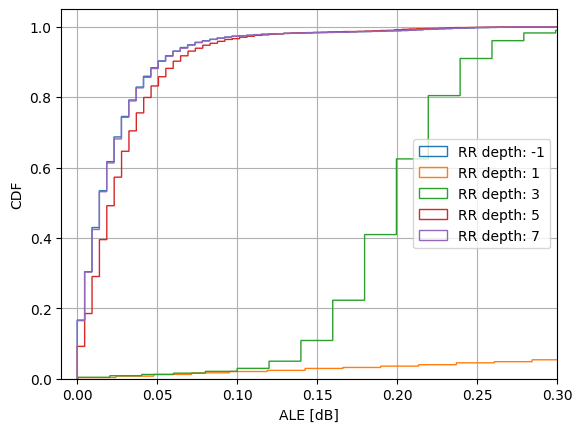

In [6]:
# Plots the CDF of the absolute logarithmic error for all evaluated depths
plt.figure()
plt.xlabel("ALE [dB]")
plt.ylabel("CDF")
plt.grid(True)
for rr_depth in rr_depths:
    cm_db = cms_db[rr_depth]
    err_map = np.abs(cm_ref_db - cm_db)
    err_valid = np.logical_not(np.logical_or(np.isnan(err_map), np.isinf(err_map)))
    err = err_map[err_valid]
    err = err.flatten()
    plt.hist(err, bins=1000, cumulative=True, density=True, histtype='step', label=f"RR depth: {rr_depth}");
plt.legend()
plt.xlim([-0.01, 0.3]);